This notebook improves upon the previous model by implementing the MLP model as described in the paper ["A Neural Probabilistic Language Model"](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) by Bengio et. al. 



This also explores the technique of batch normalization and it's importance, as described by Sergey Ioffe and Christian Szegedy in the paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167).



Finally, there are some diagnostic visualizations that help in seeing how the model parameters evolve over time, which help us in choosing the correct hyperparameters, such as learning rate, gain, and weight initialisation.



In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [236]:
words = open('names.txt','r').read().splitlines()
print(f"Number of words: {len(words)} \nExamples: {words[:8]}")

Number of words: 32033 
Examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [237]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos,"\n",vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 
 27


In [238]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append to the context 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # Training split 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # Validation split 10%
Xte, Yte = build_dataset(words[n2:]) # Test split 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [239]:
# For the first 5 words: 
# emma
# ... ---> e
# ..e ---> m
# .em ---> m
# emm ---> a
# mma ---> .
# olivia
# ... ---> o
# ..o ---> l
# .ol ---> i
# oli ---> v
# liv ---> i
# ivi ---> a
# via ---> .
# ava
# ... ---> a
# ..a ---> v
# .av ---> a
# ava ---> .
# isabella
# ... ---> i
# ..i ---> s
# .is ---> a
# isa ---> b
# sab ---> e
# abe ---> l
# bel ---> l
# ell ---> a
# lla ---> .
# sophia
# ... ---> s
# ..s ---> o
# .so ---> p
# sop ---> h
# oph ---> i
# phi ---> a
# hia ---> .

In [250]:
# Create the MLP 
n_embd = 10 # the dimensionality of the character embedding vectors 
n_hidden = 200 # the number of neurons in the hidden layer of the MLP 

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C : Lookup table: Example: 27 chars --> 2 dimensions
C = torch.randn((vocab_size, n_embd),             generator=g) # 10 dimensinal embeddings

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 3 x 10 inputs = 30 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # For fixing inital loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for fixing intial loss 

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Number of total parameters: {sum(p.nelement() for p in parameters)}')

Number of total parameters: 11897


In [251]:
# h = torch.tanh(emb.view(-1,6) @ W1 + b1) # -1 will make PyTorch infer the shape based on the other dimension
# emb.view(32,6) is the same operation as:
# 1. torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim =1)
# 2. torch.cat(torch.unbind(emb,1),dim = 1)  # INEFFICIENT: Creates new memory 
# But much faster 

In [252]:
# Optimization 
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch X and Y 
    
    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors 
    embcat = emb.view(emb.shape[0],-1) # Concatenate the vectors 
    
    h_preact = h + b1 # Hidden layer preactivation
    h = torch.tanh(h_preact) # Hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # Step learning rate decay 
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    if i%10_000 == 0: # Print every 10k steps 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
#     stepi.append(i)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


Now, after scaling W2 and b2 appropriately, so that the loss at initialization is what we expect, the plot of the loss doesn't look like a "hockey stick" shape. Because, in the case of the "hockey stick" the optimzation just squashes the logits and then rearragning the logits very quickly. 

So fixing the inital loss, removes this "easy" part of the loss function where the weights are just being shrunk down.

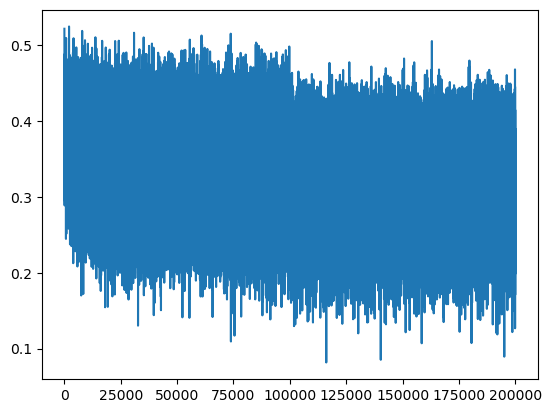

In [254]:
plt.plot(lossi)

Text(0.5, 1.0, 'tanh activation function')

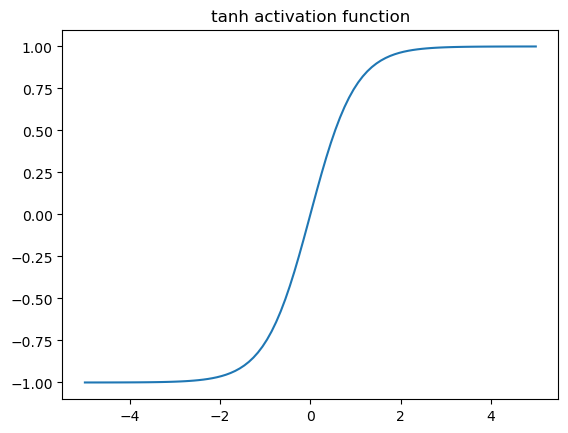

In [273]:
import numpy as np 
m = np.linspace ( - 5 , 5 , 100 )
n= torch.tanh (torch.FloatTensor (m))
plt. plot (m, n.numpy ())
plt.title("tanh activation function")

Looking at the histogram of the h (hidden layer) parameters, we see that most of the weights are very close to -1 and 1, due to the squashing performed by the tanh function. **This is not good** 

Why? 

When we perform backprop through the network, the loss propagates through all the layers, including the tanh layer. The derivative of the tanh layer (also implemented in micrograd) is along the lines of: 

`(1 - t**2) * GLOBAL_GRAD` ;  *where t is the tanh function* 

So if the values are equal to either 1 or -1, the gradient will be 0, and effectively **stopping** the backpropagation. 

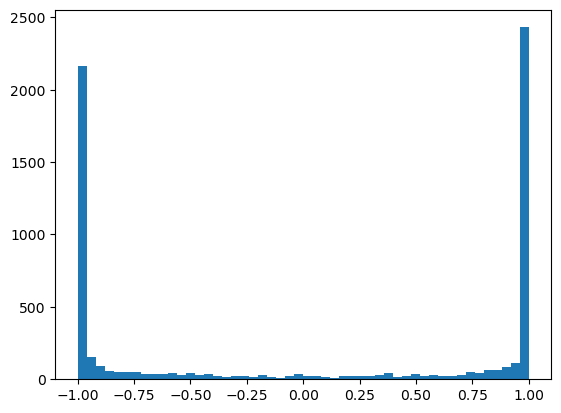

In [258]:
plt.hist(h.view(-1).tolist(), 50);

Plotting the preactivation h, shows that the values are too extreme. 

This results in a very saturated hidden layer, which leads to less training for these neurons, since they update less frequently.

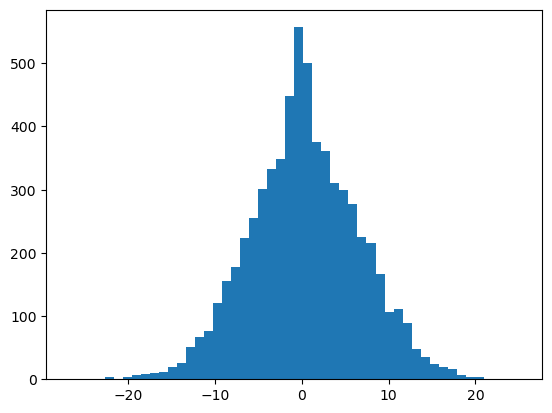

In [260]:
plt.hist(h_preact.view(-1).tolist(),50);

We can try plotting the absolute values of h, and seeing how often it is in the "flat" region of the tanh. 

> White represents when it's true, black represents when it's false 

If the entire colum was white, that would be a major problem, because that would make it a **"dead neuron"** where no single example makes the neuron learn. 



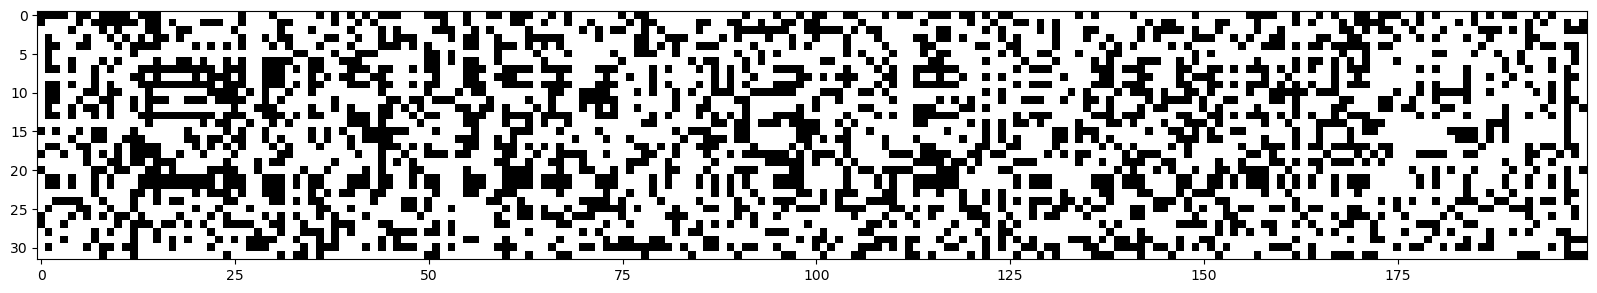

In [263]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

To fix this, `h_preact` is too far off from zero and that's what causing the issue. We want the `h_preact` to be closer to 0. We can do something very similar to what we did to fix the initial loss: 

- Multiply the bias with a small number 
- Multiply the weights with a small number to squash them

In [255]:
@torch.no_grad() # Disable gradient tracking 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte, Yte),
    }[split]
    
    # Evaluate the model on the corresponding split
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat@W1 +b1) # N x n_hidden
    logits = h@W2 + b2 # N x vocab_size
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')
    
split_loss('train')
split_loss('val')


train loss: 2.0695888996124268
val loss: 2.131074905395508


Running the newer improved model: 

In [279]:
# Create the MLP 
n_embd = 10 # the dimensionality of the character embedding vectors 
n_hidden = 200 # the number of neurons in the hidden layer of the MLP 

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C : Lookup table: Example: 27 chars --> 2 dimensions
C = torch.randn((vocab_size, n_embd),             generator=g) 

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # For fixing inital loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for fixing intial loss 

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Number of total parameters: {sum(p.nelement() for p in parameters)}')

Number of total parameters: 11897


Just running on the first batch of 32 examples

In [280]:
# Optimization 
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch X and Y 
    
    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors 
    embcat = emb.view(emb.shape[0],-1) # Concatenate the vectors 
    
    h_preact = embcat @ W1 + b1 # Hidden layer preactivation
    h = torch.tanh(h_preact) # Hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # Step learning rate decay 
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    if i%10_000 == 0: # Print every 10k steps 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3135


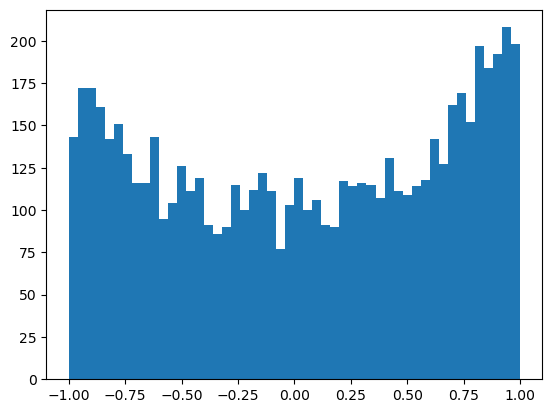

In [281]:
plt.hist(h.view(-1).tolist(), 50);

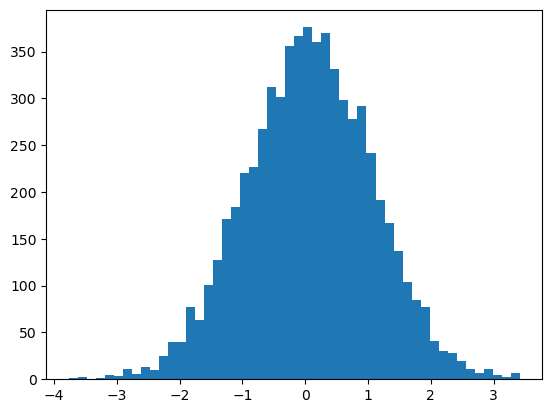

In [282]:
plt.hist(h_preact.view(-1).tolist(),50);

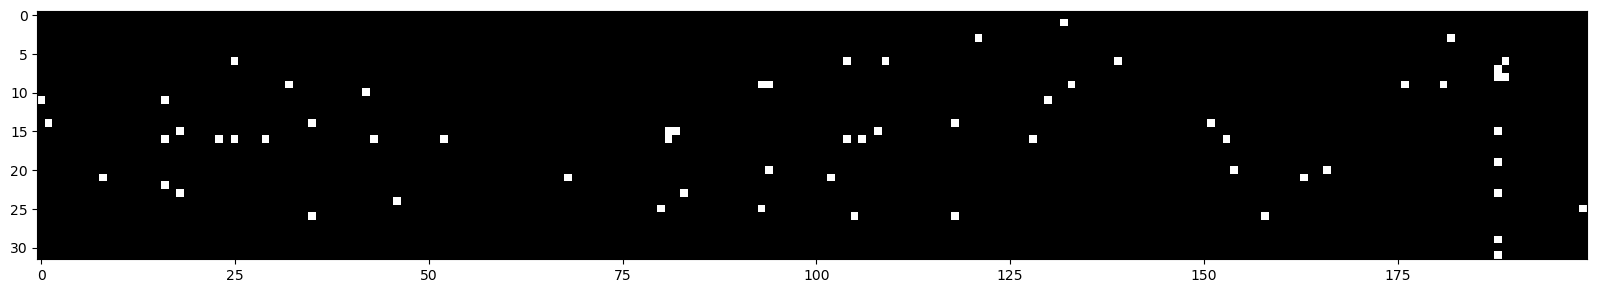

In [283]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

So, that's good - there are VERY few neurons that are saturated in either direction! 

Run for the full dataset 

In [284]:
# Optimization 
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch X and Y 
    
    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors 
    embcat = emb.view(emb.shape[0],-1) # Concatenate the vectors 
    
    h_preact = embcat @ W1 + b1 # Hidden layer preactivation
    h = torch.tanh(h_preact) # Hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # Step learning rate decay 
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    if i%10_000 == 0: # Print every 10k steps 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


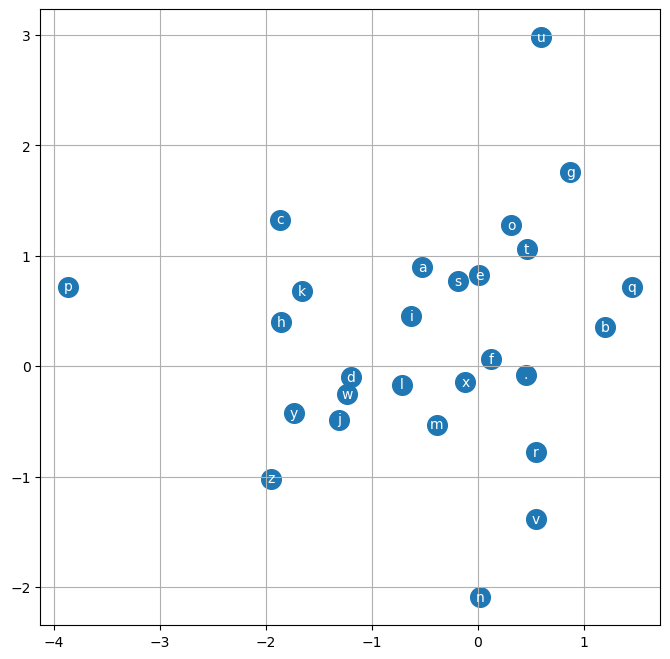

In [285]:
# Visualize the dimensions 0 and 1 of the embedding matrix
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center" , color = "white")

plt.grid('minor')

In [286]:
# Sample from the model and generate names 
g = torch.Generator().manual_seed(2147483647 + 10) 

for _ in range(20):
    
    out = []
    context = [0] * block_size # init with all "..."
    while True: 
        # forward pass the neural net 
        emb = C[torch.tensor([context])] # 1 x block_size x n_embd
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits , dim = 1)
        ix = torch.multinomial(probs, num_samples = 1 , generator = g).item()   # sample from the distribution 
        context = context[1:] + [ix] # shift the context window and track the samples
        out.append(ix)
        # if the '.' is sampled, then finish
        if ix == 0: 
            break
     
    print("".join(itos[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


## Torch-fying the code!

The classes here are the same API as `nn.Module` in PyTorch and mimic the way they are implemented in PyTorch. 


Also adding Batch-normalization to the layers.

Why?

Normalizing the hidden states to be roughly Gaussian at initialization. This gives stability to the model, but it has it's own demerits - such as coupling the inputs of the "batches" together. 

- If they are too small -> tanh is inactive 
- If they are too big   -> tanh is saturated -> **no gradient flow** 

In [349]:
class Linear: 
    def __init__(self, fan_in, fan_out, bias = True): # fan_in: # of inputs , fan_out: # of outputs 
        self.weight = torch.randn((fan_in, fan_out) , generator = g) / fan_in ** 0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None 
    
    def __call__(self, x): 
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Params: that are trained with backprop 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers: that are trained with a running 'momentum' update (exponential moving average)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self,x):
        # forward pass
        if self.training: 
            xmean = x.mean(0,keepdim=True) # mean of the batch 
            xvar = x.var(0, keepdim = True) # variance of the batch 
            
        else: 
            xmean = self.running_mean 
            xvar = self.running_var 
        
        xhat = (x-xmean) / torch.sqrt( xvar + self.eps) # normalize to unit variance, eps to avoid dividing by zero
        self.out = self.gamma * xhat + self.beta 
        
        # update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar 

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return [] 
    

In [350]:
n_emd = 10 # dimensionality of the character embedding vectors 
n_hidden = 100 # number of neurons in the hidden layer of the MLP 
g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((vocab_size , n_embd), generator = g) # Lookup table 

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]


with torch.no_grad():
    # last layer: make it less confident
    layers[-1].weight *= 0.1
    # for all the other layers apply a gain, like the kaiming initialization
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3
            
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


46497


In [351]:
# Optimization same as before 
max_steps = 200_000
batch_size = 32
lossi = []
ud = [] # update to data ratio 


for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch X and Y 
    
    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors 
    x = emb.view(emb.shape[0],-1) # Concatenate the vectors 
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad() # 
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # Step learning rate decay 
    for p in parameters:
        p.data += -lr * p.grad # The "update"
        
    # Track stats
    if i%10_000 == 0: # Print every 10k steps 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        # taking log for a nicer vizualization
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters]) 
    if i == 1000:
        break

      0/ 200000: 3.2962


## Diagnostic visualization tools

1. Plot the histogram of the forward pass activations, specifically for the `tanh` layers.

**"Saturation"** here refers to how much the neurons are in the "tails" of the `tanh` function, which means that will **stop** the gradients. So we don't want this to be too high.



Since the gain for the tanh is set to `5/3`, as we go deeper in the tanh layers, the distribution starts to stabilise. If the gain is 1 (no gain), the standard deviation will shrink and then saturation will become 0% as we go deeper. This is due to the *squashing* nature of the tanh. Therefore, some gain is necessary to help it to keep expanding, to *fight the squashing.* 

layer 1 Tanh: mean -0.04 std 0.76 saturated: 21.97%
layer 3 Tanh: mean -0.01 std 0.72 saturated: 11.00%
layer 5 Tanh: mean 0.01 std 0.73 saturated: 13.00%
layer 7 Tanh: mean -0.05 std 0.73 saturated: 13.34%
layer 9 Tanh: mean 0.00 std 0.72 saturated: 10.53%


Text(0.5, 1.0, 'Distribution of the activations')

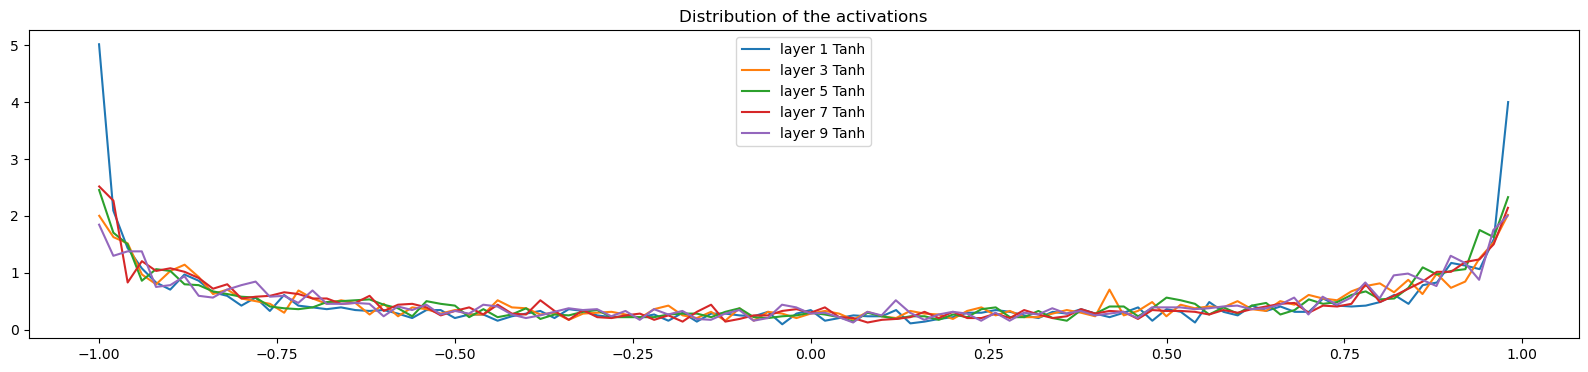

In [352]:
# vizualize the histograms of the tanh layers 
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # excluding the last softmax layer 
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} {layer.__class__.__name__}: mean {t.mean():.2f} std {t.std():.2f} saturated: {((t.abs() > 0.97).float().mean() * 100):.2f}%")
        hy, hx = torch.histogram(t, density=True)
        
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
        
plt.legend(legends);
plt.title('Distribution of the activations')

2. Similarly, we can do the exact same thing for the gradients. What we are looking for is that, all of the differnent `tanh` layers, have roughly the same distribution. They are not shrinking or exploding. 


If the gain is too low, the gradients with then expand out, which is not desirable. If the gain is too high, there will be too much of assymtery. 

layer 1 Tanh: mean 0.000024 std 0.003354
layer 3 Tanh: mean 0.000012 std 0.003157
layer 5 Tanh: mean -0.000004 std 0.002926
layer 7 Tanh: mean 0.000036 std 0.002716
layer 9 Tanh: mean 0.000020 std 0.002308


Text(0.5, 1.0, 'Distribution of the gradients')

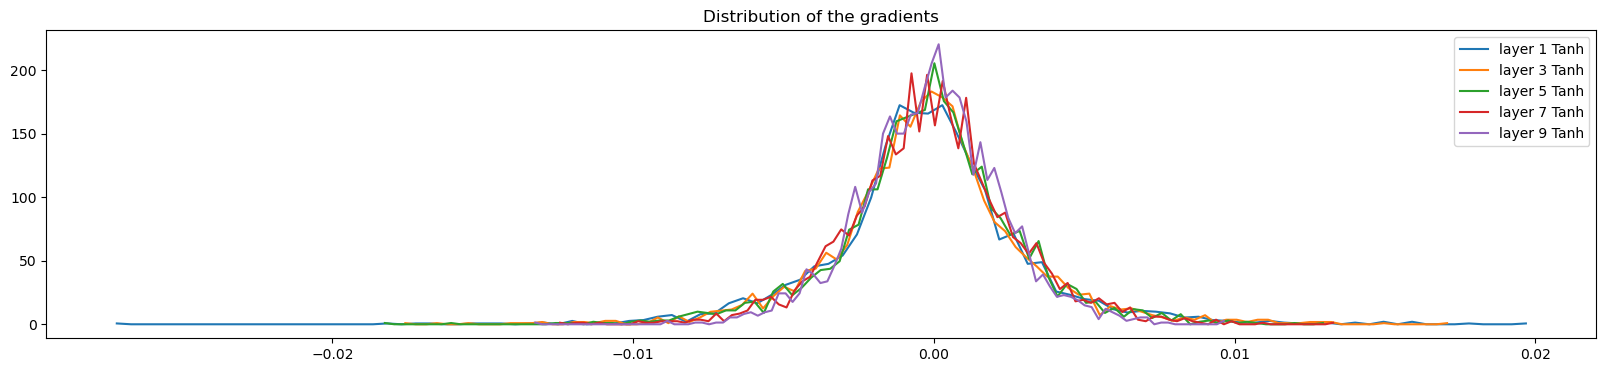

In [353]:
# vizualize the histograms of the gradients
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # excluding the last softmax layer 
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} {layer.__class__.__name__}: mean {t.mean():.6f} std {t.std():.6f}")
        hy, hx = torch.histogram(t, density=True)
        
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
        
plt.legend(legends);
plt.title('Distribution of the gradients')

Before techqnues like batch-norm or optimizers like Adam or Residual connections, training neural nets was very unstable, like "balancing a pencil on a finger." Which made training very deep networks very difficult.

3. Another plot is to visualize what's happening to the weights of the parameters. 

The `gradient/data` ratio gives a sense of what is the scale of the gradient, compared to the scale of the actual values. This is important because we take a step update (`learning rate * grad`) on the data. 

So if the grad has too large in magnitude, compared to the data, that'd be problematic. 



weight (27, 10) 	 | mean +0.000980 | std +0.011892 | grad:data ratio 0.011891
weight (30, 100) 	 | mean +0.000118 | std +0.010053 | grad:data ratio 0.032146
weight (100, 100) 	 | mean +0.000033 | std +0.007821 | grad:data ratio 0.046534
weight (100, 100) 	 | mean -0.000107 | std +0.006656 | grad:data ratio 0.039258
weight (100, 100) 	 | mean -0.000017 | std +0.006086 | grad:data ratio 0.036058
weight (100, 100) 	 | mean -0.000077 | std +0.005076 | grad:data ratio 0.030153
weight (100, 27) 	 | mean -0.000000 | std +0.020566 | grad:data ratio 0.290991


Text(0.5, 1.0, 'weights gradient distribution')

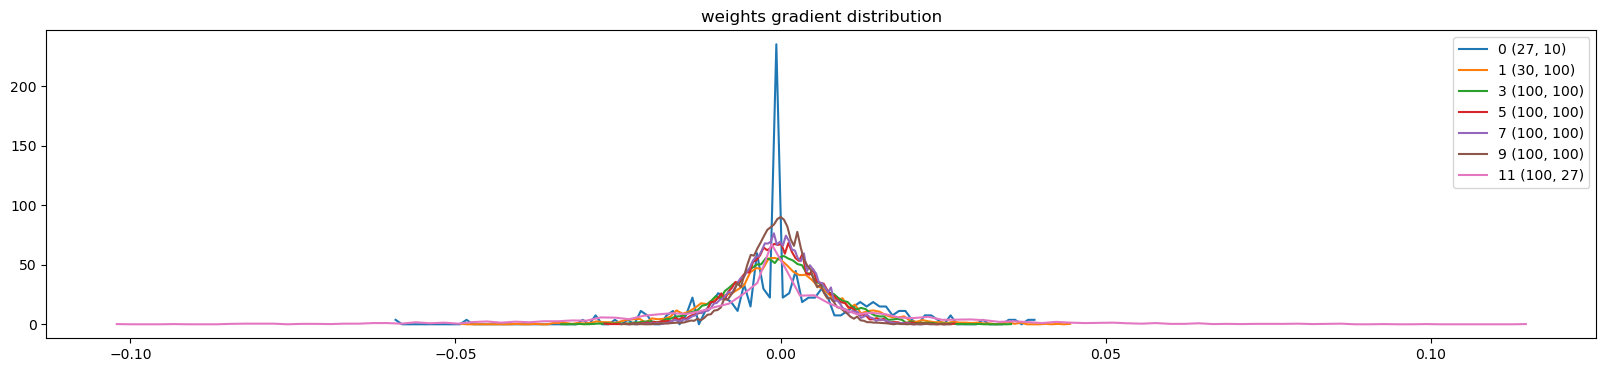

In [354]:
plt.figure(figsize = (20,4))
legends = []

for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # Skipping the biases, and the gammas and betas of the batch norm 
        print(f'weight {tuple(p.shape)} \t | mean {t.mean():+.6f} | std {t.std():+.6f} | grad:data ratio {t.std()/p.std():.6f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution')

The `grad/data` ratio is not *THAT* informative. Because what matters in the end is not the `grad/data` ratio, but the update to the data ratio. Because that is the amount with which we will actually change the data. 



As we see, the ratios evolve with training time, and stabilize during training. 

The final layer is an outlier (pink), because it was artifically shrunk down to make the softmax *"less" confident.* 

If the ratios for the layers are below the line, that means the parameters are not trained fast enough , which probably would be due a **low** learning rate. 



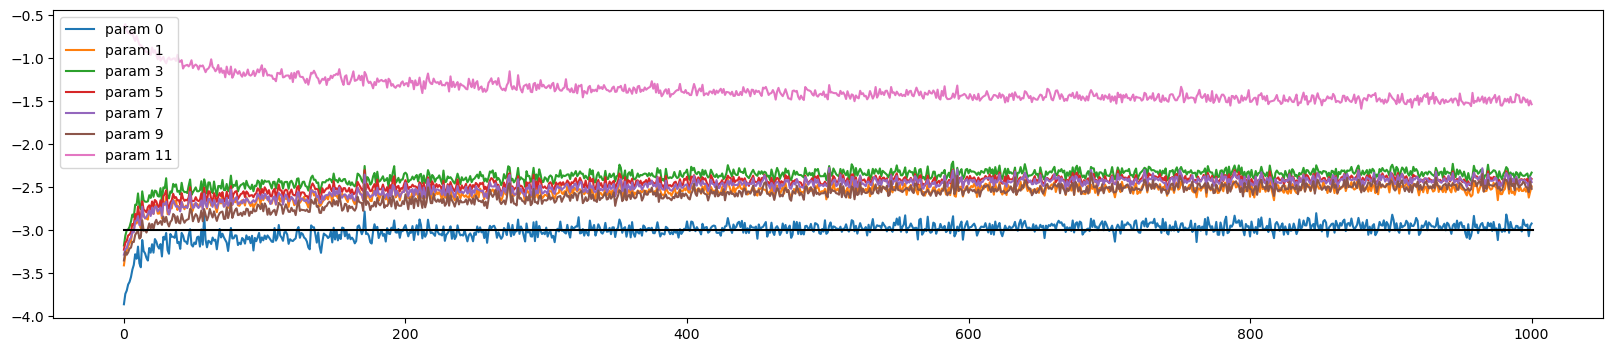

In [360]:
plt.figure(figsize = (20,4))
legends = []

for i,p in enumerate(parameters):
    if p.ndim == 2: # Skipping the biases, and the gammas and betas of the batch norm 
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")

plt.plot([0, len(ud)], [-3,-3], 'k') # the update ratio should be roughly 1e-3
        
plt.legend(legends)

The focus of this notebook was not to improve to model performance significantly, but to rather understand how the initialization of the weights and their update rules affect the model in detail

It is most likely that the character length is a bottleneck to our current model, so to improve the performance we would need to move on to more sophisticated model architechtures, as covered in later notebooks.

